In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

<h1> 2D QPI Emulation </h1>

In [22]:
train_dir = r'C:\rkka_Projects\cell_death_v1\Data\live_dead_qpi_emul\less\train'
test_dir = r'C:\rkka_Projects\cell_death_v1\Data\live_dead_qpi_emul\less\test'

In [24]:
# Define a custom dataset class
class AugmentedCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collect images from 'live' and 'dead' folders
        for label, class_name in enumerate(['live', 'dead']):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)  # 0 for live, 1 for dead

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
# Create dataset
train_dataset = AugmentedCellDataset(root_dir=train_dir, transform=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1.transforms())
validation_dataset = AugmentedCellDataset(root_dir=test_dir, transform=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1.transforms())

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

<h1> Finetune only last layer </h1>

In [26]:
from torchvision import models
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)

# Freeze parameters except last layer(fc layer)
for param in model.parameters():
    param.requires_grad = False
# Modify the final layer for binary classification (2 classes: live, dead)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Training loop
num_epochs = 30
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")
    
    torch.save(model.state_dict(), 'finetuning/less/qpi_only_last_layer/effv2_finetuned_epoch_'+str(epoch).zfill(2)+'_accuracy_'+str(val_acc)[:5]+'.pth')
    
print("Training complete!")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Loss: 0.4218, Accuracy: 82.52%
Validation Loss: 0.3954, Validation Accuracy: 88.54%



  3%|▎         | 1/30 [00:20<09:51, 20.41s/it]

Epoch [2/30], Loss: 0.2495, Accuracy: 92.64%
Validation Loss: 0.2514, Validation Accuracy: 91.67%



  7%|▋         | 2/30 [00:38<08:54, 19.08s/it]

Epoch [3/30], Loss: 0.1414, Accuracy: 96.93%
Validation Loss: 0.2072, Validation Accuracy: 97.92%



 10%|█         | 3/30 [00:56<08:26, 18.77s/it]

Epoch [4/30], Loss: 0.1338, Accuracy: 97.24%
Validation Loss: 0.1901, Validation Accuracy: 97.92%



 13%|█▎        | 4/30 [01:15<08:03, 18.58s/it]

Epoch [5/30], Loss: 0.1447, Accuracy: 96.32%
Validation Loss: 0.1864, Validation Accuracy: 97.92%



 17%|█▋        | 5/30 [01:34<07:46, 18.65s/it]

Epoch [6/30], Loss: 0.1209, Accuracy: 97.55%
Validation Loss: 0.1856, Validation Accuracy: 97.92%



 20%|██        | 6/30 [01:52<07:25, 18.57s/it]

Epoch [7/30], Loss: 0.0905, Accuracy: 98.47%
Validation Loss: 0.1754, Validation Accuracy: 97.92%



 23%|██▎       | 7/30 [02:10<07:05, 18.51s/it]

Epoch [8/30], Loss: 0.1450, Accuracy: 95.09%
Validation Loss: 0.1725, Validation Accuracy: 97.92%



 27%|██▋       | 8/30 [02:29<06:47, 18.53s/it]

Epoch [9/30], Loss: 0.0869, Accuracy: 97.85%
Validation Loss: 0.1658, Validation Accuracy: 97.92%



 30%|███       | 9/30 [02:47<06:29, 18.55s/it]

Epoch [10/30], Loss: 0.1408, Accuracy: 95.71%
Validation Loss: 0.1613, Validation Accuracy: 97.92%



 33%|███▎      | 10/30 [03:06<06:11, 18.56s/it]

Epoch [11/30], Loss: 0.1309, Accuracy: 96.01%
Validation Loss: 0.1840, Validation Accuracy: 97.92%



 37%|███▋      | 11/30 [03:24<05:50, 18.44s/it]

Epoch [12/30], Loss: 0.1266, Accuracy: 97.55%
Validation Loss: 0.1845, Validation Accuracy: 97.92%



 40%|████      | 12/30 [03:43<05:31, 18.44s/it]

Epoch [13/30], Loss: 0.0983, Accuracy: 97.55%
Validation Loss: 0.1634, Validation Accuracy: 97.92%



 43%|████▎     | 13/30 [04:01<05:13, 18.43s/it]

Epoch [14/30], Loss: 0.0998, Accuracy: 96.63%
Validation Loss: 0.1690, Validation Accuracy: 97.92%



 47%|████▋     | 14/30 [04:19<04:54, 18.42s/it]

Epoch [15/30], Loss: 0.0834, Accuracy: 97.24%
Validation Loss: 0.1895, Validation Accuracy: 97.92%



 50%|█████     | 15/30 [04:38<04:37, 18.48s/it]

Epoch [16/30], Loss: 0.0494, Accuracy: 98.47%
Validation Loss: 0.1721, Validation Accuracy: 97.92%



 53%|█████▎    | 16/30 [04:57<04:19, 18.53s/it]

Epoch [17/30], Loss: 0.0918, Accuracy: 98.47%
Validation Loss: 0.1749, Validation Accuracy: 97.92%



 57%|█████▋    | 17/30 [05:15<04:00, 18.49s/it]

Epoch [18/30], Loss: 0.0920, Accuracy: 97.55%
Validation Loss: 0.1824, Validation Accuracy: 97.92%



 60%|██████    | 18/30 [05:34<03:41, 18.49s/it]

Epoch [19/30], Loss: 0.0649, Accuracy: 98.77%
Validation Loss: 0.1869, Validation Accuracy: 97.92%



 63%|██████▎   | 19/30 [05:52<03:22, 18.43s/it]

Epoch [20/30], Loss: 0.0764, Accuracy: 98.16%
Validation Loss: 0.1823, Validation Accuracy: 97.92%



 67%|██████▋   | 20/30 [06:10<03:04, 18.41s/it]

Epoch [21/30], Loss: 0.1183, Accuracy: 95.71%
Validation Loss: 0.1922, Validation Accuracy: 97.92%



 70%|███████   | 21/30 [06:28<02:44, 18.32s/it]

Epoch [22/30], Loss: 0.0712, Accuracy: 97.55%
Validation Loss: 0.1980, Validation Accuracy: 97.92%



 73%|███████▎  | 22/30 [06:47<02:26, 18.37s/it]

Epoch [23/30], Loss: 0.0826, Accuracy: 97.85%
Validation Loss: 0.1838, Validation Accuracy: 97.92%



 77%|███████▋  | 23/30 [07:05<02:08, 18.36s/it]

Epoch [24/30], Loss: 0.0726, Accuracy: 97.85%
Validation Loss: 0.1935, Validation Accuracy: 97.92%



 80%|████████  | 24/30 [07:24<01:50, 18.38s/it]

Epoch [25/30], Loss: 0.1714, Accuracy: 96.32%
Validation Loss: 0.1923, Validation Accuracy: 97.92%



 83%|████████▎ | 25/30 [07:42<01:32, 18.51s/it]

Epoch [26/30], Loss: 0.2112, Accuracy: 94.79%
Validation Loss: 0.1892, Validation Accuracy: 96.88%



 87%|████████▋ | 26/30 [08:01<01:14, 18.59s/it]

Epoch [27/30], Loss: 0.0753, Accuracy: 97.24%
Validation Loss: 0.2236, Validation Accuracy: 97.92%



 90%|█████████ | 27/30 [08:20<00:55, 18.60s/it]

Epoch [28/30], Loss: 0.1053, Accuracy: 96.93%
Validation Loss: 0.1907, Validation Accuracy: 97.92%



 93%|█████████▎| 28/30 [08:38<00:37, 18.59s/it]

Epoch [29/30], Loss: 0.0990, Accuracy: 97.55%
Validation Loss: 0.1763, Validation Accuracy: 97.92%



 97%|█████████▋| 29/30 [08:57<00:18, 18.59s/it]

Epoch [30/30], Loss: 0.0870, Accuracy: 96.63%
Validation Loss: 0.2084, Validation Accuracy: 97.92%



100%|██████████| 30/30 [09:16<00:00, 18.54s/it]

Training complete!


<h1> Confusion matrix </h1>

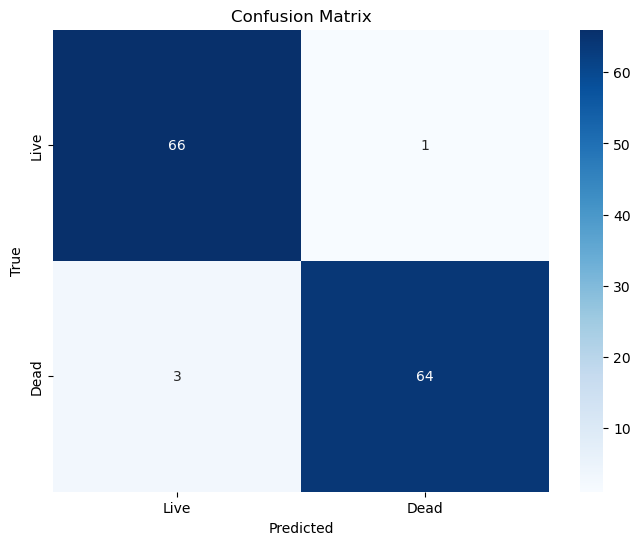

In [13]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# After training, collect predictions and actual labels from the validation set
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Live', 'Dead'], yticklabels=['Live', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<h1> MIP </h1>

In [28]:
train_dir = r'C:\rkka_Projects\cell_death_v1\Data\live_dead_mip\less\train'
test_dir = r'C:\rkka_Projects\cell_death_v1\Data\live_dead_mip\less\test'

# Create dataset
train_dataset = AugmentedCellDataset(root_dir=train_dir, transform=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1.transforms())
validation_dataset = AugmentedCellDataset(root_dir=test_dir, transform=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1.transforms())

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [29]:
from torchvision import models
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)

# Freeze parameters except last layer(fc layer)
for param in model.parameters():
    param.requires_grad = False
# Modify the final layer for binary classification (2 classes: live, dead)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Training loop
num_epochs = 30
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")
    
    torch.save(model.state_dict(), 'finetuning/less/mip_only_last_layer/effv2_finetuned_epoch_'+str(epoch).zfill(2)+'_accuracy_'+str(val_acc)[:5]+'.pth')
    
print("Training complete!")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Loss: 0.5613, Accuracy: 70.30%
Validation Loss: 0.3469, Validation Accuracy: 96.74%



  3%|▎         | 1/30 [00:19<09:35, 19.85s/it]

Epoch [2/30], Loss: 0.2899, Accuracy: 92.73%
Validation Loss: 0.2220, Validation Accuracy: 97.83%



  7%|▋         | 2/30 [00:37<08:33, 18.33s/it]

Epoch [3/30], Loss: 0.2045, Accuracy: 94.85%
Validation Loss: 0.1641, Validation Accuracy: 97.83%



 10%|█         | 3/30 [00:54<08:02, 17.88s/it]

Epoch [4/30], Loss: 0.1918, Accuracy: 94.55%
Validation Loss: 0.1393, Validation Accuracy: 95.65%



 13%|█▎        | 4/30 [01:11<07:36, 17.57s/it]

Epoch [5/30], Loss: 0.2368, Accuracy: 90.61%
Validation Loss: 0.1501, Validation Accuracy: 95.65%



 17%|█▋        | 5/30 [01:28<07:17, 17.50s/it]

Epoch [6/30], Loss: 0.1794, Accuracy: 95.15%
Validation Loss: 0.1062, Validation Accuracy: 97.83%



 20%|██        | 6/30 [01:46<06:58, 17.43s/it]

Epoch [7/30], Loss: 0.1569, Accuracy: 95.76%
Validation Loss: 0.1198, Validation Accuracy: 97.83%



 23%|██▎       | 7/30 [02:03<06:41, 17.45s/it]

Epoch [8/30], Loss: 0.1398, Accuracy: 96.36%
Validation Loss: 0.1045, Validation Accuracy: 97.83%



 27%|██▋       | 8/30 [02:21<06:23, 17.45s/it]

Epoch [9/30], Loss: 0.1763, Accuracy: 95.15%
Validation Loss: 0.1238, Validation Accuracy: 96.74%



 30%|███       | 9/30 [02:38<06:07, 17.51s/it]

Epoch [10/30], Loss: 0.1651, Accuracy: 93.33%
Validation Loss: 0.1096, Validation Accuracy: 97.83%



 33%|███▎      | 10/30 [02:56<05:49, 17.48s/it]

Epoch [11/30], Loss: 0.1510, Accuracy: 94.24%
Validation Loss: 0.1064, Validation Accuracy: 97.83%



 37%|███▋      | 11/30 [03:13<05:33, 17.56s/it]

Epoch [12/30], Loss: 0.1543, Accuracy: 96.97%
Validation Loss: 0.0996, Validation Accuracy: 97.83%



 40%|████      | 12/30 [03:31<05:14, 17.49s/it]

Epoch [13/30], Loss: 0.1036, Accuracy: 96.97%
Validation Loss: 0.1033, Validation Accuracy: 97.83%



 43%|████▎     | 13/30 [03:48<04:58, 17.54s/it]

Epoch [14/30], Loss: 0.1098, Accuracy: 97.27%
Validation Loss: 0.1045, Validation Accuracy: 97.83%



 47%|████▋     | 14/30 [04:06<04:39, 17.48s/it]

Epoch [15/30], Loss: 0.1271, Accuracy: 95.45%
Validation Loss: 0.1043, Validation Accuracy: 97.83%



 50%|█████     | 15/30 [04:23<04:20, 17.37s/it]

Epoch [16/30], Loss: 0.1094, Accuracy: 96.97%
Validation Loss: 0.1088, Validation Accuracy: 97.83%



 53%|█████▎    | 16/30 [04:40<04:02, 17.34s/it]

Epoch [17/30], Loss: 0.1178, Accuracy: 96.36%
Validation Loss: 0.1022, Validation Accuracy: 97.83%



 57%|█████▋    | 17/30 [04:57<03:44, 17.30s/it]

Epoch [18/30], Loss: 0.1131, Accuracy: 96.97%
Validation Loss: 0.1075, Validation Accuracy: 97.83%



 60%|██████    | 18/30 [05:15<03:28, 17.41s/it]

Epoch [19/30], Loss: 0.1504, Accuracy: 95.45%
Validation Loss: 0.0988, Validation Accuracy: 97.83%



 63%|██████▎   | 19/30 [05:33<03:11, 17.42s/it]

Epoch [20/30], Loss: 0.1338, Accuracy: 95.45%
Validation Loss: 0.1426, Validation Accuracy: 97.83%



 67%|██████▋   | 20/30 [05:50<02:54, 17.42s/it]

Epoch [21/30], Loss: 0.1268, Accuracy: 95.45%
Validation Loss: 0.0969, Validation Accuracy: 97.83%



 70%|███████   | 21/30 [06:07<02:36, 17.42s/it]

Epoch [22/30], Loss: 0.1033, Accuracy: 96.36%
Validation Loss: 0.0982, Validation Accuracy: 97.83%



 73%|███████▎  | 22/30 [06:25<02:19, 17.46s/it]

Epoch [23/30], Loss: 0.1084, Accuracy: 96.36%
Validation Loss: 0.1055, Validation Accuracy: 97.83%



 77%|███████▋  | 23/30 [06:42<02:02, 17.48s/it]

Epoch [24/30], Loss: 0.1005, Accuracy: 97.58%
Validation Loss: 0.1015, Validation Accuracy: 97.83%



 80%|████████  | 24/30 [07:00<01:45, 17.50s/it]

Epoch [25/30], Loss: 0.0975, Accuracy: 95.76%
Validation Loss: 0.0998, Validation Accuracy: 97.83%



 83%|████████▎ | 25/30 [07:17<01:27, 17.50s/it]

Epoch [26/30], Loss: 0.0958, Accuracy: 96.67%
Validation Loss: 0.1100, Validation Accuracy: 97.83%



 87%|████████▋ | 26/30 [07:35<01:10, 17.52s/it]

Epoch [27/30], Loss: 0.1078, Accuracy: 96.97%
Validation Loss: 0.1080, Validation Accuracy: 97.83%



 90%|█████████ | 27/30 [07:53<00:52, 17.54s/it]

Epoch [28/30], Loss: 0.1266, Accuracy: 95.45%
Validation Loss: 0.0874, Validation Accuracy: 97.83%



 93%|█████████▎| 28/30 [08:10<00:35, 17.55s/it]

Epoch [29/30], Loss: 0.1537, Accuracy: 95.76%
Validation Loss: 0.0851, Validation Accuracy: 97.83%



 97%|█████████▋| 29/30 [08:28<00:17, 17.57s/it]

Epoch [30/30], Loss: 0.1665, Accuracy: 94.85%
Validation Loss: 0.1136, Validation Accuracy: 97.83%



100%|██████████| 30/30 [08:45<00:00, 17.51s/it]

Training complete!


<h1> Confusion matrix </h1>

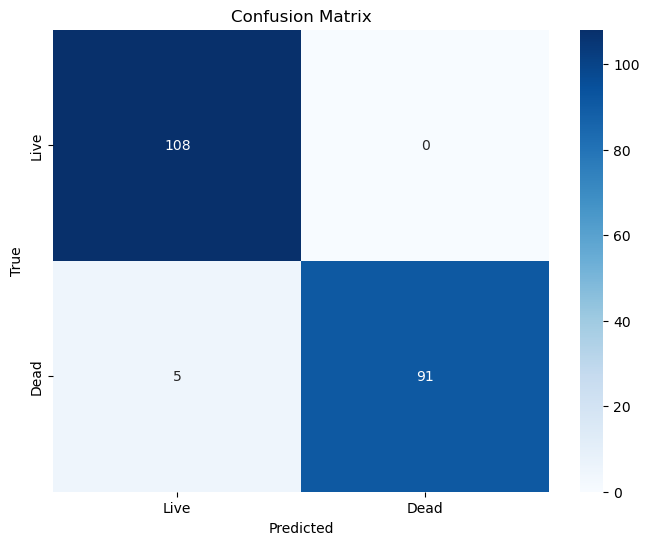

In [8]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# After training, collect predictions and actual labels from the validation set
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Live', 'Dead'], yticklabels=['Live', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Visualize model prediction

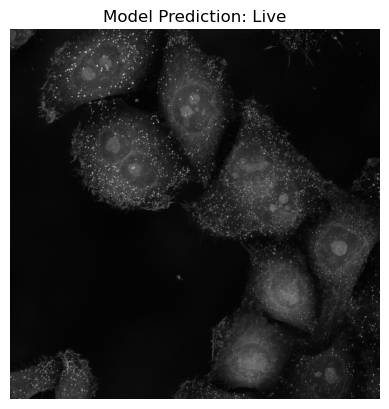

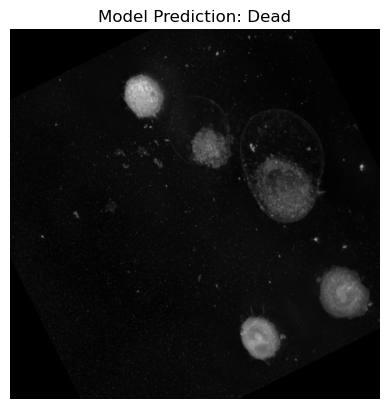

In [31]:
import torch
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained model (make sure it's the same as the one you trained)
model.eval()

# Define the image transformation
transform = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1.transforms()

# Function to load, transform, and predict for a single image
def load_and_predict(image_path, model):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transform
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move image to the same device as the model
    image = image.to(device)
    
    # Get the model's prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

# Paths to representative images
live_image_path = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\test\augmented\live\16_HT_0000.png"  # Replace with actual path
dead_image_path = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\test\augmented\dead\48_HT_0053_aug_4.png"  # Replace with actual path

# Predict for both images
live_prediction = load_and_predict(live_image_path, model)
dead_prediction = load_and_predict(dead_image_path, model)

# Mapping predictions to class labels
class_labels = ['Live', 'Dead']

# Display the images with predictions
def display_image_with_prediction(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Model Prediction: {class_labels[prediction]}")
    plt.axis('off')
    plt.show()

# Show live image with prediction
display_image_with_prediction(live_image_path, live_prediction)

# Show dead image with prediction
display_image_with_prediction(dead_image_path, dead_prediction)


In [ ]:
model.eval()  # Set model to evaluation mode
i = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = outputs.max(1)

        

<h1> Finetune all layers </h1>

In [84]:
from torchvision import models
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights)

# Modify the final layer for binary classification (2 classes: live, dead)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")
    
    torch.save(model.state_dict(), 'finetuning/all_layers/effv2_finetuned_epoch_'+str(epoch).zfill(2)+'_accuracy_'+str(val_acc)[:5]+'.pth')

print("Training complete!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.1954, Accuracy: 91.96%
Validation Loss: 0.0391, Validation Accuracy: 98.61%



 10%|█         | 1/10 [15:25<2:18:51, 925.73s/it]

Epoch [2/10], Loss: 0.1081, Accuracy: 96.26%
Validation Loss: 0.0317, Validation Accuracy: 98.89%



 20%|██        | 2/10 [30:57<2:03:53, 929.24s/it]

Epoch [3/10], Loss: 0.0489, Accuracy: 98.34%
Validation Loss: 0.0043, Validation Accuracy: 100.00%



 30%|███       | 3/10 [46:26<1:48:23, 929.07s/it]

Epoch [4/10], Loss: 0.0856, Accuracy: 96.88%
Validation Loss: 0.0973, Validation Accuracy: 96.12%



 40%|████      | 4/10 [1:01:59<1:33:04, 930.72s/it]

Epoch [5/10], Loss: 0.0528, Accuracy: 97.92%
Validation Loss: 0.0917, Validation Accuracy: 95.01%



 50%|█████     | 5/10 [1:17:28<1:17:30, 930.04s/it]

Epoch [6/10], Loss: 0.0571, Accuracy: 98.06%
Validation Loss: 0.1340, Validation Accuracy: 96.68%



 60%|██████    | 6/10 [1:32:56<1:01:57, 929.32s/it]

Epoch [7/10], Loss: 0.0850, Accuracy: 97.37%
Validation Loss: 0.1071, Validation Accuracy: 97.78%



 70%|███████   | 7/10 [1:48:24<46:26, 928.86s/it]  

Epoch [8/10], Loss: 0.0925, Accuracy: 98.27%
Validation Loss: 0.0730, Validation Accuracy: 96.68%



 80%|████████  | 8/10 [2:03:54<30:58, 929.46s/it]

Epoch [9/10], Loss: 0.1242, Accuracy: 96.74%
Validation Loss: 0.0216, Validation Accuracy: 99.45%



 90%|█████████ | 9/10 [2:19:25<15:29, 929.67s/it]

Epoch [10/10], Loss: 0.0976, Accuracy: 96.95%
Validation Loss: 0.1827, Validation Accuracy: 92.52%



100%|██████████| 10/10 [2:34:54<00:00, 929.45s/it]

Training complete!


<h1> Test to new data </h1>

In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms

In [8]:
model = models.efficientnet_v2_l()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(state_dict=torch.load(r'C:\rkka_Projects\cell_death_v1\finetuning\only_last_layer\effv2_finetuned_epoch_35_accuracy_97.54.pth'))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20824\3737496184.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load(r'C:\rkka_Projects

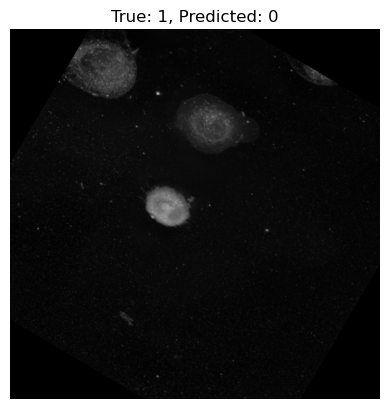

In [9]:
# Modified evaluation loop to track misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

# Set model to evaluation mode
model.eval()

# Ensure no gradient calculations are done
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Check for misclassifications
        for idx in range(len(labels)):
            if predicted[idx] != labels[idx]:
                # Get the corresponding image file path
                image_path = validation_dataset.image_paths[i * batch_size + idx]  # Adjust index for the batch
                misclassified_images.append(image_path)
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())

# Now `misclassified_images` will contain the file paths of misclassified images,
# `misclassified_labels` will contain their true labels, and `misclassified_preds` will contain the wrong predictions.

# Example: Displaying one misclassified image
from PIL import Image
import matplotlib.pyplot as plt

if len(misclassified_images) > 0:
    # Load the first misclassified image
    misclassified_image = Image.open(misclassified_images[0])
    plt.imshow(misclassified_image)
    plt.title(f"True: {misclassified_labels[0]}, Predicted: {misclassified_preds[0]}")
    plt.axis('off')
    plt.show()
else:
    print("No misclassified images found.")


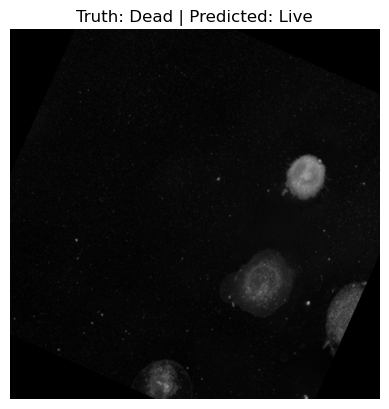

In [21]:
# Example: Displaying one misclassified image
from PIL import Image
import matplotlib.pyplot as plt

if len(misclassified_images) > 0:
    # Load the first misclassified image
    misclassified_image = Image.open(misclassified_images[1])
    plt.imshow(misclassified_image)
    # plt.title(f"True: {misclassified_labels[0]}, Predicted: {misclassified_preds[0]}")
    plt.title(f"Truth: Dead | Predicted: Live")
    plt.axis('off')
    plt.show()
else:
    print("No misclassified images found.")


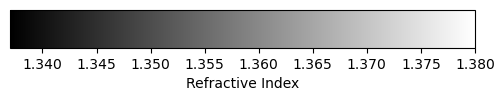

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the range for the colorbar
vmin = 1.337
vmax = 1.380

# Create a color map (white to black)
cmap = plt.cm.gray

# Create a figure and axis for the colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the defined range
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')

# Set the colorbar labels
cbar.set_label('Refractive Index')

# Display the colorbar
plt.show()
